<h1>NLP Logistic Regression with L1 (Lasso) regularization</h1>

In [4]:
# Regular Expressions
import re

# Data manipulation
import numpy as np
import pandas as pd

# NLP
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

# Train & testing, vectorization & model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import classification_report

# Charts
import matplotlib.pyplot as plt
import seaborn as sns

import json

<h3>Data is about 51,762 USA Congress law projects from year 1993 to 2010, every entry is annotated (1,0) whether it survived or not the Congress commitee</h3>
<p>Get data from <a href="http://www.cs.cmu.edu/~ark/bills/">here</a></p>

In [5]:
def get_data(data_dir):
    """Load Raw Data"""

    
    bills = []
    with open(f'{data_dir}/raw/billtext_org.json') as f:
        for line in f.readlines():
            bill_id, bill_data = line.split('\t', 1)
            bill_data = json.loads(bill_data)
            bill = {"id": bill_id}
            bill.update(bill_data)
            bills.append(bill)
    pre_data = pd.DataFrame(bills).set_index('id')
    pre_data

    # Load labels
    data_dirs = [f'{data_dir}/{i}' for i in range(103, 112)]
    bills = []
    for data_dir in data_dirs:
        with open(f'{data_dir}/response.json', 'r') as f:
            for line in f.readlines():
                bill_id, bill_response = line.split('\t', 1)
                bills.append({
                    'id': bill_id,
                    'response': int(bill_response.replace('\n', ''))
                })
    pre_responses = pd.DataFrame(bills).set_index('id')

    # Join text + labels
    return pre_data.join(pre_responses)
    
# Create stemmer
st = PorterStemmer()

# Stop words, words that give no information
cached_stopwords = stopwords.words('english') + [r'mr', r'ms', r'mrs']

# Regular Exp to remove everything that is not a letter from a to z
punctuation_re = re.compile('[^a-z]+')

def pre_processing(text):
    """Process the given text. To lowercase, replace new lines for spaces,
    remove punctuation marks, digits, stop words and stem words"""
    return " ".join(
        [
         st.stem(word) for word in punctuation_re.sub(
             ' ', 
             str(text).lower().replace('\n', ' ')
             ).split()
             if len(word) > 2 and word not in cached_stopwords       
         ]
         )

In [6]:
data = get_data('D:\\MY_DOWNLOADS\\Congressional_Bill_Corpus.v1.00\\Congressional_Bill_Corpus.v1.00\\')

In [7]:
data

,text,title,response
id,,,
C103-HR4449,4449 IH\n103d CONGRESS\n2d Session\n H. R. 444...,To amend part A of title IV of the Social Secu...,0
C103-HR4448,4448 IH\n103d CONGRESS\n2d Session\n H. R. 444...,To amend the Act establishing Lowell National ...,1
C103-HR2944,2944 IH\n103d CONGRESS\n1st Session\n H. R. 29...,To provide grants to the States for drug testi...,0
C103-HR2945,2945 IH\n103d CONGRESS\n1st Session\n H. R. 29...,To amend the Federal Election Campaign Act of ...,0
C103-HR2942,2942 IH\n103d CONGRESS\n1st Session\n H. R. 29...,To designate certain lands in the Commonwealth...,1
...,...,...,...
C111-HR4236,4236 IH\n111th CONGRESS\n1st Session\n H. R. 4...,To amend the Internal Revenue Code of 1986 to ...,0
C111-HR2459,2459 IH\n111th CONGRESS\n1st Session\n H. R. 2...,To amend the Public Health Service Act with re...,0
C111-HR2493,2493 IH\n111th CONGRESS\n1st Session\n H. R. 2...,To prevent wealthy and middle-income foreign s...,0


In [8]:
print(data.text[4])

2942 IH
103d CONGRESS
1st Session
 H. R. 2942
To designate certain lands in the Commonwealth of Virginia as a National Scenic Area for protection of the watershed and scenic values, recreation use, protection of wildlife and their habitat, and for other purposes.
IN THE HOUSE OF REPRESENTATIVES
August 6, 1993
Mr. GOODLATTE introduced the following bill; which was referred to the Committee on Agriculture

A BILL
To designate certain lands in the Commonwealth of Virginia as a National Scenic Area for protection of the watershed and scenic values, recreation use, protection of wildlife and their habitat, and for other purposes.
  Be it enacted by the Senate and House of Representatives of the United States of America in Congress assembled,
SECTION 1. SHORT TITLE.
  This Act may be cited as the `Mount Pleasant National Scenic Area Act'.
SEC. 2. PURPOSES.
  The purposes of this Act with respect to the Mount Pleasant National Scenic Area are to--
  (1) ensure appropriate protection and prese

In [9]:
data.response.value_counts()

0    44934
1     6828
Name: response, dtype: int64

<h3>Pre-processing</h3>
<p>Split into trainning and testing data sets</p>

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data.text, data.response, train_size =.7, random_state=10)
print(X_train.shape, X_test.shape)

(36233,) (15529,)


<p>preprocess and save result into csv</p>

In [12]:
from tqdm import tqdm
tqdm.pandas()
X_train_proc = X_train.progress_apply(pre_processing)

100%|██████████| 36233/36233 [17:15<00:00, 34.98it/s]  


In [14]:
X_train_proc.to_csv("D:\\MY_DOWNLOADS\\Congressional_Bill_Corpus.v1.00\\Congressional_Bill_Corpus.v1.00\\X_proc.csv")

<p>Load preprocessing file</p>

In [15]:
X_train_proc = pd.read_csv("D:\\MY_DOWNLOADS\\Congressional_Bill_Corpus.v1.00\\Congressional_Bill_Corpus.v1.00\\X_proc.csv", index_col=0).text
X_train_proc

id
C110-HR1779    congress session amend higher educ act extend ...
C108-HR541     congress session amend intern revenu code prov...
C111-HR4711    congress session provid deliveri vehicl fleet ...
C110-HR2700    congress session suspend implement absolut pri...
C110-HR1754    congress session establish hous ethic commiss ...
                                     ...                        
C108-HR1830    congress session amend immigr nation act provi...
C111-HR1309    congress session codifi definit term use subhe...
C108-HR1873    congress session amend intern revenu code prov...
C110-HR1605    congress session amend titl unit state code re...
C106-HR4417    congress session provid secretari commerc cont...
Name: text, Length: 36233, dtype: object

<p>drop NaNs and match x train & y train indexes</p>

In [27]:
X_train_proc = X_train_proc.dropna()

In [65]:
mask = y_train.index.isin(X_train_proc.index)

In [68]:
y_train = y_train.loc[mask]

In [69]:
y_train

id
C110-HR1779    0
C108-HR541     0
C111-HR4711    0
C110-HR2700    0
C110-HR1754    0
              ..
C108-HR1830    0
C111-HR1309    0
C108-HR1873    0
C110-HR1605    0
C106-HR4417    0
Name: response, Length: 35602, dtype: int64

<h3>Vectorization (word bagging)</h3>

In [70]:
vect = TfidfVectorizer(min_df = .05, max_df = .95)
bow = vect.fit_transform(X_train_proc)
bow

<35602x916 sparse matrix of type '<class 'numpy.float64'>'
	with 4817097 stored elements in Compressed Sparse Row format>

In [71]:
pd.DataFrame(bow.todense(), columns = vect.get_feature_names())

,abil,abus,accept,access,accord,account,achiev,acquir,acquisit,act,...,work,worker,workforc,world,would,write,written,xviii,year,york
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.124823,...,0.000000,0.000000,0.0,0.0,0.000000,0.063787,0.000000,0.0,0.190310,0.0
1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.302793,0.041639,0.0,0.0,0.000000,0.000000,0.034022,0.0,0.017135,0.0
2,0.0,0.000000,0.000000,0.000000,0.000000,0.021147,0.000000,0.057491,0.0,0.057816,...,0.000000,0.000000,0.0,0.0,0.020854,0.000000,0.000000,0.0,0.068211,0.0
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.051499,...,0.000000,0.000000,0.0,0.0,0.000000,0.038013,0.000000,0.0,0.064808,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35597,0.0,0.007898,0.006278,0.011272,0.031734,0.019743,0.006631,0.000000,0.0,0.040485,...,0.022508,0.046428,0.0,0.0,0.009735,0.014942,0.000000,0.0,0.047763,0.0
35598,0.0,0.000000,0.000000,0.000000,0.039961,0.000000,0.000000,0.000000,0.0,0.019826,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
35599,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.100064,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.106248,0.0
35600,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.046658,...,0.014591,0.020065,0.0,0.0,0.012622,0.000000,0.000000,0.0,0.066055,0.0


<h2>Modells</h2>
<h3>Logistic Regression with L1</h3>

In [72]:
log_l1 = LogisticRegressionCV(cv=5, random_state=2, penalty = 'l1', solver = 'liblinear', n_jobs = -1).fit(bow, y_train)

In [74]:
log_l1.C_

array([0.35938137])

In [75]:
X_test_proc = X_test.progress_apply(pre_processing)

100%|██████████| 15529/15529 [06:25<00:00, 40.31it/s]


In [77]:
X_test_proc = X_test_proc.dropna()

In [79]:
X_test_proc.to_csv("X_test_proc.csv")

In [80]:
bow_test = vect.transform(X_test_proc)

In [81]:
print(classification_report(y_test, log_l1.predict(bow_test)))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93     13453
           1       0.64      0.14      0.23      2076

    accuracy                           0.87     15529
   macro avg       0.76      0.56      0.58     15529
weighted avg       0.85      0.87      0.84     15529



<h3>Logistic Regression without regularization</h3>

In [83]:
log = LogisticRegression(penalty='none', max_iter = 1000).fit(bow, y_train)

In [84]:
print(classification_report(y_test, log.predict(bow_test)))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93     13453
           1       0.58      0.21      0.31      2076

    accuracy                           0.87     15529
   macro avg       0.73      0.59      0.62     15529
weighted avg       0.85      0.87      0.85     15529



<h3>Coefficient comparison</h3>
<p>From charts it can be seen:</p>
<p>- Lasso makes nearly every coefficient 0</p>
<p>- If regularization is not used nearly every variable will affect the final result</p>

<ipython-input-86-2738fb56f485>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


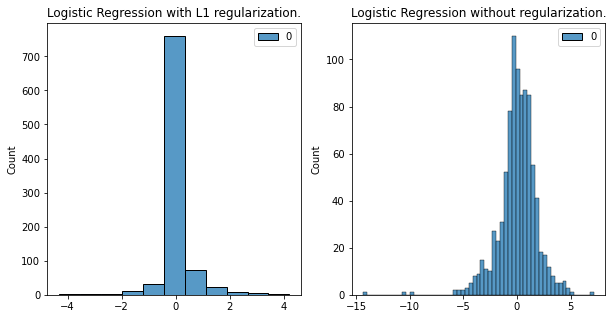

In [86]:
fig, ax =plt.subplots(1,2)

fig.set_size_inches(10, 5)

sns.histplot(list(log_l1.coef_), ax=ax[0]).set_title('Logistic Regression with L1 regularization.')
sns.histplot(list(log.coef_), ax=ax[1]).set_title('Logistic Regression without regularization.')

fig.show()

<p><b>It can be seen that 235 variables or words are enough to get 65% precision to know whether a project law will be accepted or not</b></p>

In [88]:
log_l1_zeros = ["zero" if x == 0 else "non-zero" for x in log_l1.coef_.tolist()[0]]
unique, counts = np.unique(log_l1_zeros, return_counts=True)
dict(zip(unique, counts))

{'non-zero': 235, 'zero': 681}

In [89]:
log_zeros = ["zero" if x == 0 else "non-zero" for x in log.coef_.tolist()[0]]
unique, counts = np.unique(log_zeros, return_counts=True)
dict(zip(unique, counts))

{'non-zero': 916}

<h3>New Law Proposal Function</h3>
<p>Assuming that the modell will be applied to figure out whether a new law proposal will be accepted or not</p>

In [92]:
def f(text, model = log_l1, vect = vect):
    return model.predict(vect.transform([pre_processing(text)]))[0]

In [93]:
X_test[:10].apply(f)

id
C109-HR20      0
C106-HR2226    0
C109-HR1906    0
C107-HR97      0
C107-HR5019    0
C103-HR3968    0
C111-HR1019    0
C108-HR1505    1
C106-HR4438    0
C103-HR2890    0
Name: text, dtype: int64